# О наборе данных

### Контекст
Компаниям-эмитентам кредитных карт важно иметь возможность распознавать мошеннические транзакции, чтобы с клиентов не взималась плата за товары, которые они не покупали.

### Содержание
Набор данных содержит транзакции, совершенные по кредитным картам в сентябре 2013 года держателями карт из Европы.

В этом наборе данных представлены транзакции, произошедшие за два дня. 492 из 284 807 транзакций мошеннические. Набор данных сильно несбалансирован, на положительный класс (мошеннические транзакции) приходится 0,172% всех транзакций.

Набор данных содержит только числовые входные переменные, которые являются результатом преобразования PCA (Principal Component Analysis). К сожалению, по соображениям конфиденциальности невозможно предоставить исходные характеристики и дополнительную справочную информацию о данных. Характеристики V1, V2, … V28 являются основными компонентами, полученными с помощью PCA, помимо них есть Time, Amount и Class:

* Time содержит время в секундах, прошедшие между текущей транзакцией и первой транзакцией в наборе данных.

* Amount представляет собой сумму транзакции, которую можно использовать для обучения с учетом затрат в зависимости от примера.

* Class, - значение в этом столбце показывает является ли транзакция мошеннической.

# Импорт библиотек:

In [1]:
import pandas as pd
import sklearn.model_selection as msl

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import resample

# Импорт данных

In [2]:
df = pd.read_csv('creditcard.csv')

df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Первым делом стоит проверить что среди записей нет "бракованных", то есть с пустыми ячейками, поскольку их невозможно использовать, для этого сложим все пустые значения в таблице.

Также проверим количество продублированных записей и удалим их.

In [3]:
empty = df.isna().sum().sum()

df_with_duplicates = len(df)
df.drop_duplicates(inplace=True)
duplicates = df_with_duplicates - len(df)

print('В таблице', empty, 'пустых записей.')
print('Из таблицы удалено', duplicates, 'продублированных записей.')

В таблице 0 пустых записей.
Из таблицы удалено 1081 продублированных записей.


Сборщиками этого набора данных уже было замечено, что набор сильно несбалансирован, поскольку мошеннических транзакций намного меньше чем обычных. Для такого набора данных в качестве метрики, например, нельзя использовать самую простую из них - Accuracy, то есть долю правильных ответов алгоритма. Для данного набора данных эта метрика может показать для алгоритма, никогда не помечающего мошеннические транзакции, результат лучший чем для того, который отлавливает хотя бы часть мошеннических транзакций.

Построим матрицу корреляции для параметров задачи. В матрице корреляции для каждой пары данных из набора посчитан коэффициент корреляции Пирсона, показывающий насколько зависимость между данными близка к линейной.

<Axes: >

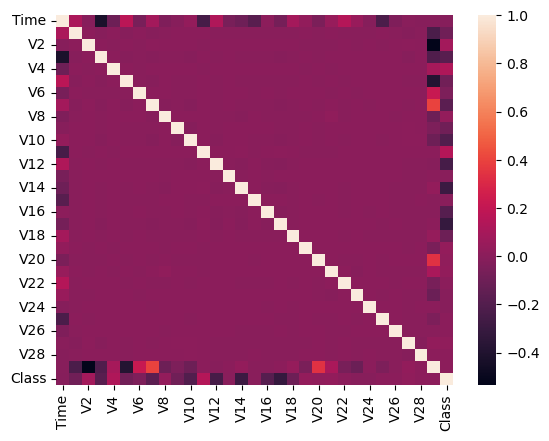

In [4]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix)

Можно видеть что параметры V1-V28 между собой никак не связаны, но имеют слабо выраженную зависимость от Time, Amount и Class.

C:\Users\mike\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


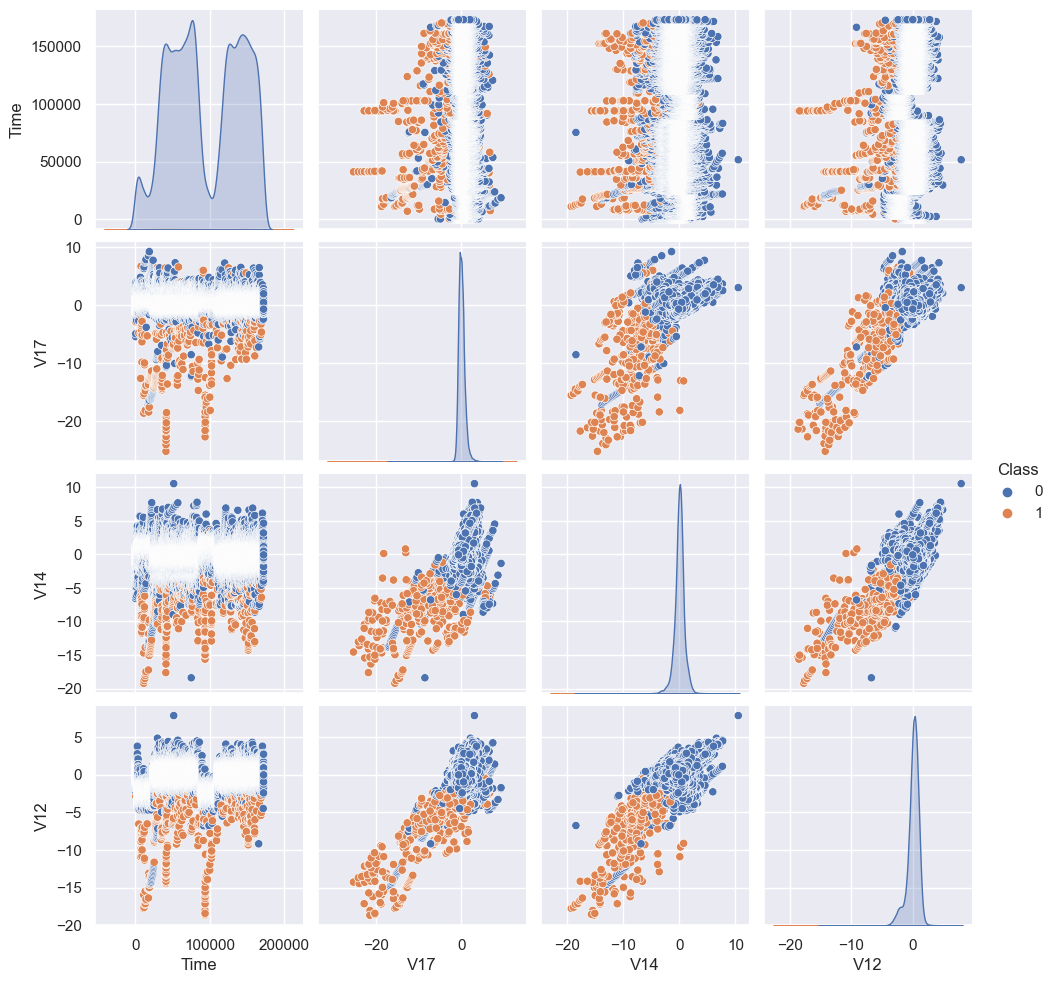

In [5]:
sns.set()
subset = df[['Time', 'V17', 'V14', 'V12', 'Class']]
sns.pairplot(subset, hue='Class')

Глядя на эти графики нельзя уверенно сказать что данные делятся линейно. Конечно можно перебрать все пары признаков, чтоб окончательно убедиться что линейно данные не разделяются нигде (или же обнаружить обратное), но есть риск потратить чрезмерное количество времени.

# Метод логистической регрессии

Для начала попробуем этот метод, поскольку он не допускает перебалансировку данных, а значит проще. Сперва разделим все данные на две выборки: тренировочную и тестовую. На первой обучим модель, на второй протестируем насколько хорошо она работает. Важно чтоб соотношение мошеннических транзакций в выборках сохранялось.

In [6]:
# Отделим все данные от столбца Class
X = df.drop(['Class'], axis=1)
y = df.Class

X_train, X_test, y_train, y_test = msl.train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)

print('Проверим что процент мошеннических транзакций в выборках совпадает.')
difference = abs(y_train.sum()/len(y_train)-y_test.sum()/len(y_test))*100
print('Разница составляет', difference, 'процентов.')

Проверим что процент мошеннических транзакций в выборках совпадает.
Разница составляет 0.00014458368676386474 процентов.


Нормализуем данные:

In [7]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [8]:
L_Reg = LogisticRegression(class_weight = 'balanced')
L_Reg.fit(X_train_scaled, y_train)
prediction = L_Reg.predict(X_test_scaled)

У нас имеется первая обученная модель и мы можем получить первые результаты обучения, но какими метриками? Выше было отмечено что Accuracy для такой несбалансированной метрики не сгодится, однако Recall, Precision и F-меру использовать можно.

Recall покажет способность алгоритма "видеть" мошеннические транзакции, а Precision - возможность отличать его от других.

F-мера же является среднегармоническим двух метрик, описанных выше.

In [9]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     93474
           1       0.05      0.90      0.10       156

    accuracy                           0.97     93630
   macro avg       0.53      0.94      0.54     93630
weighted avg       1.00      0.97      0.98     93630



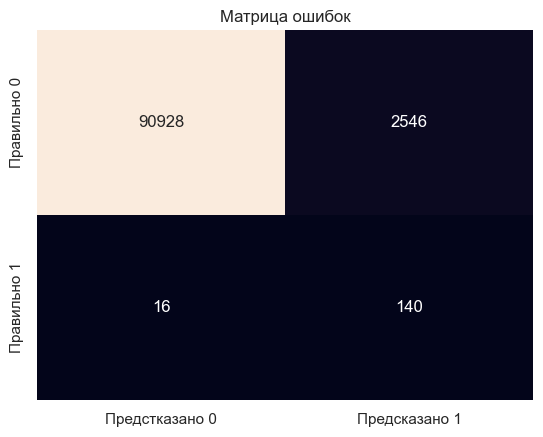

In [10]:
Conf_Mat = confusion_matrix(y_test, prediction)

sns.heatmap(Conf_Mat, annot=True, fmt="d", cbar=False,
            xticklabels=['Предстказано 0', 'Предсказано 1'],
            yticklabels=['Правильно 0', 'Правильно 1'])


plt.title('Матрица ошибок')
plt.show()

## Результаты обучения модели логистической регрессии

### Precision
Для мошеннических транзакций результат плохой - всего 7%, что говорит о том, что предсказывая их, алгоритм в основном ошибается.

### recall
Показатели recall для обоих классов достаточно высокие, это означает что модель хорошо обнаруживает оба класса.

### f1-score
Видно, что f1-score для класса мошеннических транзакций низкий, что свидетельствует о трудностях модели в их обнаружении.

# Балансировка выборки

Метод логистической регрессии не допускал перебалансировки данных, но далее попробуем методы, которые допускают её, это должно повысить точность алгоритма.

In [4]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from sklearn.ensemble import RandomForestClassifier

sampler = RandomOverSampler(random_state=42)
X_train_sampled, y_train_sampled = sampler.fit_resample(X_train_scaled, y_train)
X_test_sampled, y_test_sampled = sampler.fit_resample(X_test_scaled, y_test)

ImportError: cannot import name '_MissingValues' from 'sklearn.utils._param_validation' (C:\Users\mike\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py)